In [1]:
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import editdistance
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

ModuleNotFoundError: No module named 'torch'

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Vocab:
    def __init__(self, counter, sos, eos, pad, unk, min_freq=None):
        self.sos = sos
        self.eos = eos
        self.pad = pad
        self.unk = unk
        
        self.pad_idx = 0
        self.unk_idx = 1
        self.sos_idx = 2
        self.eos_idx = 3
        
        self._token2idx = {
            self.sos: self.sos_idx,
            self.eos: self.eos_idx,
            self.pad: self.pad_idx,
            self.unk: self.unk_idx,
        }
        self._idx2token = {idx:token for token, idx in self._token2idx.items()}
        
        idx = len(self._token2idx)
        min_freq = 0 if min_freq is None else min_freq
        
        for token, count in counter.items():
            if count > min_freq:
                self._token2idx[token] = idx
                self._idx2token[idx]   = token
                idx += 1
        
        self.vocab_size = len(self._token2idx)
        self.tokens     = list(self._token2idx.keys())
    
    def token2idx(self, token):
        return self._token2idx.get(token, self.pad_idx)
    
    def idx2token(self, idx):
        return self._idx2token.get(idx, self.pad)
    
    def __len__(self):
        return len(self._token2idx)
    
def padding(sequences, pad_idx):
    '''
    Inputs:
        sequences: list of list of tokens
    '''
    max_length = max(map(len, sequences))
    
    return [seq + [pad_idx]*(max_length - len(seq)) for seq in sequences]



import csv
from collections import Counter

def words_tokenize(line):
    return list(line)

def trans_tokenize(line):
    return line.split()

class Dataset(object):
    def __init__(self, path):
        val_size = 0.1
        shuffle  = True

        with open(path, 'r') as f:
            reader = csv.reader(f)
            lines   = list(reader)

        _, words, trans = zip(*lines[1:])

        c = list(zip(words, trans))
        random.shuffle(c)
        words, trans = zip(*c)

        val_size = int(len(words) * val_size)
        train_words, val_words = words[val_size:], words[:val_size]
        train_trans, val_trans = trans[val_size:], trans[:val_size]
        
        words_counter = Counter()
        trans_counter = Counter()

        for line in train_words:
            tokens = words_tokenize(line)
            for token in tokens:
                words_counter[token] += 1

        for line in train_trans:
            tokens = trans_tokenize(line)
            for token in tokens:
                trans_counter[token] += 1
                
        sos = "<sos>"
        eos = "<eos>"
        pad = "<pad>"
        unk = "<unk>"

        self.words_vocab = Vocab(words_counter, 
                            sos, eos, pad, unk)

        self.trans_vocab = Vocab(trans_counter, 
                            sos, eos, pad, unk)
        
        self.train_words = [[self.words_vocab.token2idx(item) for item in words_tokenize(word)] for word in train_words]
        self.val_words   = [[self.words_vocab.token2idx(item) for item in words_tokenize(word)] for word in val_words]

        self.train_trans = [[self.trans_vocab.token2idx(item) for item in trans_tokenize(trans)] for trans in train_trans]
        self.val_trans   = [[self.trans_vocab.token2idx(item) for item in trans_tokenize(trans)] for trans in val_trans]
        
    def __len__(self):
        return len(self.train_trans)
        
    def get_batch(self, batch_size, sort=False, val=False):
        if val:
            words, trans = self.val_words,   self.val_trans
        else:
            words, trans = self.train_words, self.train_trans

        random_ids = np.random.randint(0, len(words), batch_size)
        batch_words = [words[idx] for idx in random_ids]
        batch_trans = [trans[idx] for idx in random_ids]

        batch_trans_in  = [[self.trans_vocab.sos_idx] + tran for tran in batch_trans]
        batch_trans_out = [tran + [self.trans_vocab.eos_idx] for tran in batch_trans]

        words_lens = list(map(len, batch_words))
        trans_lens = list(map(len, batch_trans_in))

        batch_words     = padding(batch_words,     pad_idx=self.words_vocab.pad_idx)
        batch_trans_in  = padding(batch_trans_in,  pad_idx=self.trans_vocab.pad_idx)
        batch_trans_out = padding(batch_trans_out, pad_idx=self.trans_vocab.pad_idx)


        batch_words     = torch.LongTensor(batch_words)
        batch_trans_in  = torch.LongTensor(batch_trans_in)
        batch_trans_out = torch.LongTensor(batch_trans_out)
        words_lens      = torch.LongTensor(words_lens)
        trans_lens      = torch.LongTensor(trans_lens)

        if sort:
            lens, indices   = torch.sort(words_lens, 0, True)
            batch_words     = batch_words[indices]
            batch_trans_in  = batch_trans_in[indices]
            batch_trans_out = batch_trans_out[indices]
            trans_lens = trans_lens[indices]
            words_lens = lens

        return batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens

In [4]:
data = Dataset('train.csv')

In [5]:
batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(32)

In [6]:
batch_words.size(), batch_trans_in.size(), batch_trans_out.size(), words_lens.size(), trans_lens.size()

(torch.Size([32, 13]),
 torch.Size([32, 14]),
 torch.Size([32, 14]),
 torch.Size([32]),
 torch.Size([32]))

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence  as unpack

class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.gru       = nn.GRU(emb_size, hidden_size)
        
    
    def forward(self, source, source_lens=None, hidden=None):
        embedded = self.embedding(source)
        embedded = embedded.transpose(0, 1)
        
        if source_lens is not None:
            embedded = pack(embedded, source_lens)
        
        if hidden is not None:
            outs, hidden = self.gru(embedded, hidden)
        else:
            outs, hidden = self.gru(embedded)
            
        return outs, hidden
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx):
        super(Decoder, self).__init__()
        self.vocab_size  = vocab_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.gru       = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.linear    = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, target, hidden):
        embedded = self.embedding(target)
        outs, hidden = self.gru(embedded, hidden)
        outs = self.linear(outs)
        pred = outs.view(-1, self.vocab_size)
        return pred, hidden
    
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
    def forward(self, batch_words, words_lens, batch_trans_in):
        _, hidden = self.encoder(batch_words, words_lens)
        logits, _   = self.decoder(batch_trans_in, hidden)
        return logits
    
    def generate(self, bos_idx, eos_idx, batch_words):
        inp = [bos_idx]
        _, hidden = self.encoder(batch_words)

        for _ in range(100):
            inp_tensor = torch.LongTensor([[inp[-1]]]).to(batch_words.device)
            logits, hidden   = self.decoder(inp_tensor, hidden)
            next_token = F.softmax(logits, dim=-1)[-1].topk(1)[1].item()
            inp.append(next_token)
            if next_token == eos_idx:
                break
        return inp

In [8]:
def plot(epoch, batch_idx, train_losses, val_losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('epoch %s. | batch: %s | loss: %s' % (epoch, batch_idx, train_losses[-1]))
    plt.plot(train_losses)
    plt.subplot(132)
    plt.title('epoch %s. | loss: %s' % (epoch, val_losses[-1]))
    plt.plot(val_losses)
    plt.show()

In [9]:
def one_step(batch_size, val):
    batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(batch_size, sort=True, val=val)

    batch_words     = batch_words.to(device)
    batch_trans_in  = batch_trans_in.to(device)
    batch_trans_out = batch_trans_out.to(device)
    words_lens      = words_lens.to(device)
    trans_lens      = trans_lens.to(device)
    
    logits = model(batch_words, words_lens, batch_trans_in)
    
    batch_trans_out = batch_trans_out.view(-1)
    mask = batch_trans_out != data.trans_vocab.pad_idx
    loss = criterion(logits[mask], batch_trans_out[mask])
    
    return loss

In [10]:
#device = torch.device("cuda" if torch.cuda.is_available else "cpu")
emb_size    = 32
hidden_size = 64
encoder = Encoder(data.words_vocab.vocab_size, emb_size, hidden_size, data.words_vocab.pad_idx).to(device)
decoder = Decoder(data.trans_vocab.vocab_size, emb_size, hidden_size, data.trans_vocab.pad_idx).to(device)
model   = Model().to(device)
model.encoder = encoder
model.decoder = decoder

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

batch_size = 32
epoch      = 0
num_epochs = 5

train_losses  = []
val_losses    = []


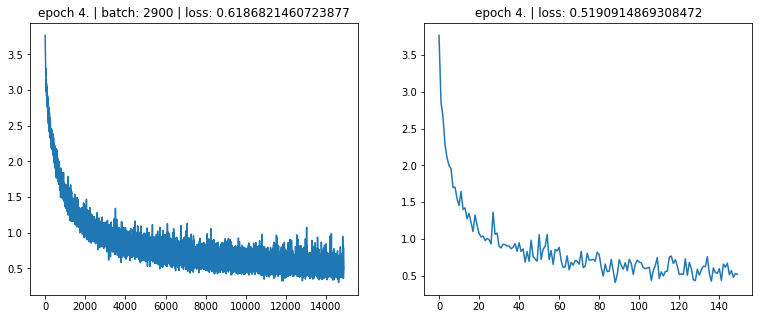

In [11]:
while epoch < num_epochs:
    for batch_idx in range(len(data) // batch_size):
        loss = one_step(batch_size, val=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if batch_idx % 100 == 0:
            with torch.no_grad():
                loss = one_step(batch_size, val=True)
                val_losses.append(loss.item())

            plot(epoch, batch_idx, train_losses, val_losses)
            
    epoch += 1

In [14]:
def _print(val):
    batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(1, sort=True, val=val)
    batch_words      = batch_words.to(device)
    batch_trans_out  = batch_trans_out.to(device)
    predicted_tokens = []
    real_tokens      = []

    inp = model.generate(data.words_vocab.sos_idx, data.words_vocab.eos_idx, batch_words)
            
    tokens = [data.trans_vocab.idx2token(idx) for idx in inp if idx not in [data.trans_vocab.sos_idx,
                                                                       data.trans_vocab.eos_idx,
                                                                       data.trans_vocab.pad_idx]]
    
    tokens_idx = [data.trans_vocab.token2idx(token) for token in tokens]
    #predicted_tokens.append(token_idx)
    real = [data.trans_vocab.idx2token(idx) for idx in batch_trans_out[0].tolist() if idx not in [data.trans_vocab.sos_idx,
                                                                            data.trans_vocab.eos_idx,
                                                                            data.trans_vocab.pad_idx]]
    real_idx = [data.trans_vocab.token2idx(token) for token in real]
    
    print('Src: ', ''.join([data.words_vocab.idx2token(idx) for idx in batch_words[0].tolist()]))
    print('Pred:', ''.join(tokens))
    #print(tokens_idx)
    print('Real:', ''.join(real))
    #print(real_idx)
    print(editdistance.eval(tokens_idx, real_idx))
    

In [16]:
for _ in range(10):
    _print(True)
    print()

Src:  JUGGLERS
Pred: JHAHGLERZ
Real: JHAHGLERZ
0

Src:  SKINNER'S
Pred: SKIHNERZ
Real: SKIHNERZ
0

Src:  IRANI
Pred: ERIYNIY
Real: IHRAANIY
3

Src:  BROPHY
Pred: BRAAFIY
Real: BROWFIY
1

Src:  ROUNDER
Pred: RAWNDER
Real: RAWNDER
0

Src:  SENSE-DATA
Pred: SEHNSAHDEYT
Real: SEHNSDEYTAH
2

Src:  HANSLEY
Pred: HHAENSLIY
Real: HHAENSLIY
0

Src:  NEDVED
Pred: NEHDVEHD
Real: NEHDVAHD
1

Src:  SCHLITTER
Pred: SHLIHTER
Real: SHLIHTER
0

Src:  DEMON
Pred: DEHMAHN
Real: DIYMAHN
1

